In [2]:
from jupyter_imports import *
from copy import deepcopy

In [3]:
# run only once
from utils.MyLogger import ExecutionLogger # use 'prod' for remote after cache_tmp
start = datetime(2022,9,16,0)#,tzinfo=timezone.utc)
dirname = os.path.join(os.sep, 'tmp','prod','tradeexecutor')#,'prod')
ExecutionLogger.batch_summarize_exec_logs(dirname=dirname,start=start,add_history_context=False,rebuild=True)

In [4]:
files = ['all_by_clientOrderId','all_by_coin','all_by_symbol','all_order_manager','all_parameters']
original = {file:pd.read_csv(os.path.join(os.sep, dirname,f'{file}.csv'),index_col=0) for file in files}

In [5]:
cmap = cm.get_cmap('Spectral')
#fig, ax = plt.subplots(1)

## parameters for reference

In [6]:
all_parameters = original['all_parameters']
all_parameters['hash'] = all_parameters['timestamp'].apply(lambda x: pd.util.hash_pandas_object(all_parameters.groupby('timestamp').get_group(x).astype(str)).sum())
all_parameters['param_index'] = all_parameters['hash'].apply(lambda h: list(all_parameters['hash'].unique()).index(h))
all_parameters.drop(columns=['hash'],inplace=True)
param_map = all_parameters.set_index('timestamp')['param_index'].to_dict()
param_map

{1663343086489.0251: 0, 1663343957341.835: 1, 1663343217549.02: 2}

In [7]:
indexed = deepcopy(original)
#for df in indexed.values():
#    df['param_index'] = df['timestamp'].apply(lambda x:param_map[x])
#colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(all_parameters['param_index'].unique())))

### slippage, fees in bps. filled in USD

In [8]:
print(indexed['all_by_symbol'].describe())
indexed['all_by_symbol']

       time_to_execute  slippage_bps  fee   filledUSD
count         2.000000      3.000000  3.0    3.000000
mean     478807.511597      6.098022  0.0  160.564933
std      429418.423984     17.218519  0.0  364.749122
min      175162.832031    -11.081867  0.0 -237.637700
25%      326985.171814     -2.530423  0.0    1.604850
50%      478807.511597      6.021021  0.0  240.847400
75%      630629.851379     14.687967  0.0  359.666250
max      782452.191162     23.354912  0.0  478.485100


,index,time_to_execute,slippage_bps,fee,filledUSD,coin
0,ETH/USD,175162.832031,-11.081867,0.0,240.8474,ETH
1,ETH/USD:USD,782452.191162,23.354912,0.0,-237.6377,ETH
2,average,NaN,6.021021,0.0,478.4851,NaN


### slippage distribution

In [9]:
print(indexed['all_by_coin'].describe())
indexed['all_by_coin']

       perleg_fee_bps  perleg_filled_USD  premium_vs_inception_bps
count             2.0            2.00000                  2.000000
mean              0.0          239.24255                 12.042042
std               0.0            0.00000                  0.000000
min               0.0          239.24255                 12.042042
25%               0.0          239.24255                 12.042042
50%               0.0          239.24255                 12.042042
75%               0.0          239.24255                 12.042042
max               0.0          239.24255                 12.042042


,index,perleg_fee_bps,perleg_filled_USD,premium_vs_inception_bps
0,ETH,0.0,239.24255,12.042042
1,average,0.0,239.24255,12.042042


# tick to ack

,index,symbol,coin,order_ref,pending_local,pending_to_ack_local,mid_at_pending,amount,filled,price,fee,last_fill_local
0,new_ETH/USD:USD_1663343170409,ETH/USD:USD,ETH,1443.6,1.663343e+12,952.629150,1440.00,-0.163,-0.163,1440.1,0,1.663343e+12
1,new_ETH/USD:USD_1663343907452,ETH/USD:USD,ETH,1443.6,1.663344e+12,350.025879,1450.55,-0.002,-0.002,1450.7,0,1.663344e+12
2,new_ETH/USD_1663342906968,ETH/USD,ETH,1443.8,1.663343e+12,377.599121,1444.05,0.167,0.167,1442.2,0,1.663343e+12


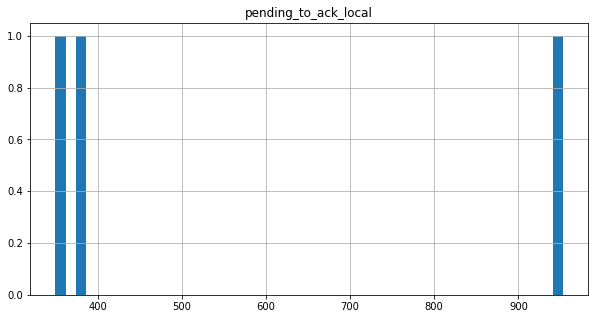

In [10]:
by_clientOrderId = indexed['all_by_clientOrderId']
tick_to_order_local = by_clientOrderId[['pending_to_ack_local']]
tick_to_order_local.hist(bins=50,figsize=(10,5))
tick_to_order_local.describe()
by_clientOrderId

# remote vs local (~ round trip)

,round_trip
count,24.000000
mean,30695.818095
std,75402.484388
min,0.023926
25%,219.875122
50%,319.496826
75%,10447.899902
max,349876.993652


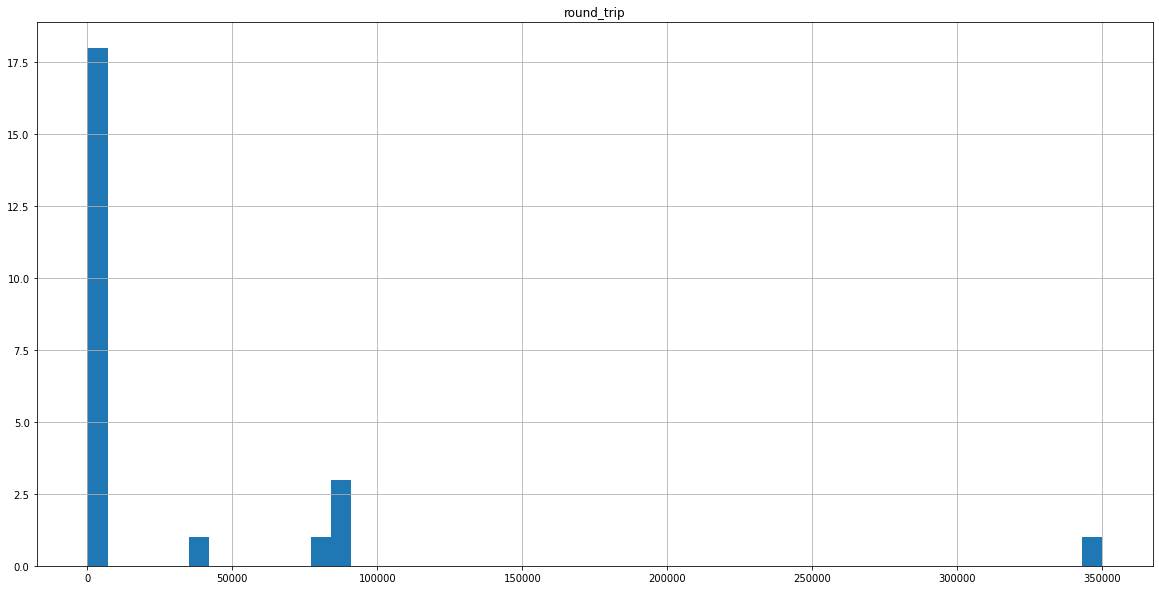

In [11]:
round_trip = pd.DataFrame(columns=['round_trip'], data = 2*(indexed['all_order_manager']['timestamp']-indexed['all_order_manager']['remote_timestamp']))
round_trip.hist(bins=50,figsize=(20,10))
round_trip.describe()
#indexed['all_order_manager'][['timestamp','remote_timestamp']] - indexed['all_parameters']['timestamp'].squeeze()